Using the attached dataset, please create a notebook (preferably Python but any tool is allowed) to explore the data in order to answer questions like:
+ **How would you make a geo expansion recommendation?**
+ **What new columns would you create?**
+ **How might clustering analysis help - how would you go about it?**

However, use these questions just as a starting point, and feel free to also use your own creativity/inspiration

In the interview process, we'll ask you to take us through your notebook, thought process and the libraries that you've used. A presentation/deck of any kind is not necessary.

[Metadata](https://carto.com/spatial-data-catalog/browser/dataset/acs_sociodemogr_f7ba0b77/data)

In [20]:
import pandas as pd 
import numpy as np
import seaborn as sns
import contextily as ctx

import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn import cluster
import libpysal
from esda.moran import Moran
from libpysal.weights import Queen, KNN

In [2]:

#loading provided dataset
df = pd.read_excel('./US Census Dataset.xlsx')
df.head()


,ID,total_pop,male_pop,female_pop,pop_25_years_over,median_age,median_income,income_per_capita,gini_index,median_rent,black_pop,hispanic_pop,white_pop,geom
0,0,48970,24123,24847,26944,27.0,51972.0,21486.0,0.3620,853.0,16810,11761,14301,"MULTIPOLYGON(((-97.874316 31.077931, -97.87367..."
1,1,809,376,433,612,56.2,29087.0,21153.0,0.4452,370.0,127,31,651,"POLYGON((-95.793207 32.036901, -95.805474 32.0..."
2,2,2330,1198,1132,1650,46.0,56400.0,29967.0,0.4528,533.0,276,254,1691,"POLYGON((-79.073703 35.659202, -79.074482 35.6..."
3,3,22171,11234,10937,15022,38.3,73226.0,30397.0,0.4187,1297.0,377,11256,8195,"POLYGON((-121.71859 36.814383, -121.715383 36...."
4,4,2829,1485,1344,2033,41.2,35064.0,20576.0,0.4633,481.0,41,21,2727,"POLYGON((-81.587423 37.749221, -81.595335 37.7..."


### GIS

In [3]:
#Checking geometry + viz
#creating geodataframe

Creating GeoDataFrame using conventional way throws an error, which indicates that there are issues with WKT

```python
gdf = gpd.GeoDataFrame(df, geometry=df['geom'])
```
Looking at the data in QGIS, the assumption that there are extra numbers (or numbers removed from a pair) which distorts geometry
<img src="./images/qgis_wkt_issue.PNG" alt="qgis_wkt_issue" width="600"/>

In [4]:
#Fixing geomertry using shapely
from shapely import wkt

geom = []

for g in df['geom']:
    try:
        geom.append(wkt.loads(g))
    except:
        geom.append(None)

df['geometry'] = geom

ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered word: '-'
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected

ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream


In [5]:
#chekcing for empty geometries
df["geometry"].isna().sum()

139

In [6]:
df.dropna(subset=['geometry'], inplace=True)

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
#CRS check
print(gdf.crs)

None


<AxesSubplot:>

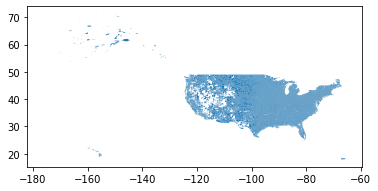

In [8]:
#quick check that data looks OK
gdf.plot()

In [11]:
#As this data covers US and is US cencus NAD83 or WGS84 coudl be used (differences will not have effect on this scale)
# setting CRS to WGS84 to avoid possilbe CRS conversions later if/when adding addtional datasets

gdf.set_crs(epsg=4326, inplace=True)
gdf.head(1)

,ID,total_pop,male_pop,female_pop,pop_25_years_over,median_age,median_income,income_per_capita,gini_index,median_rent,black_pop,hispanic_pop,white_pop,geom,geometry
0,0,48970,24123,24847,26944,27.0,51972.0,21486.0,0.362,853.0,16810,11761,14301,"MULTIPOLYGON(((-97.874316 31.077931, -97.87367...","MULTIPOLYGON (((-97.87432 31.07793, -97.87367 ..."


In [19]:
ethnic_groups = ['black_pop', 'hispanic_pop', 'white_pop']

In [12]:
gdf.columns

Index(['ID', 'total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop', 'geom',
       'geometry'],
      dtype='object')

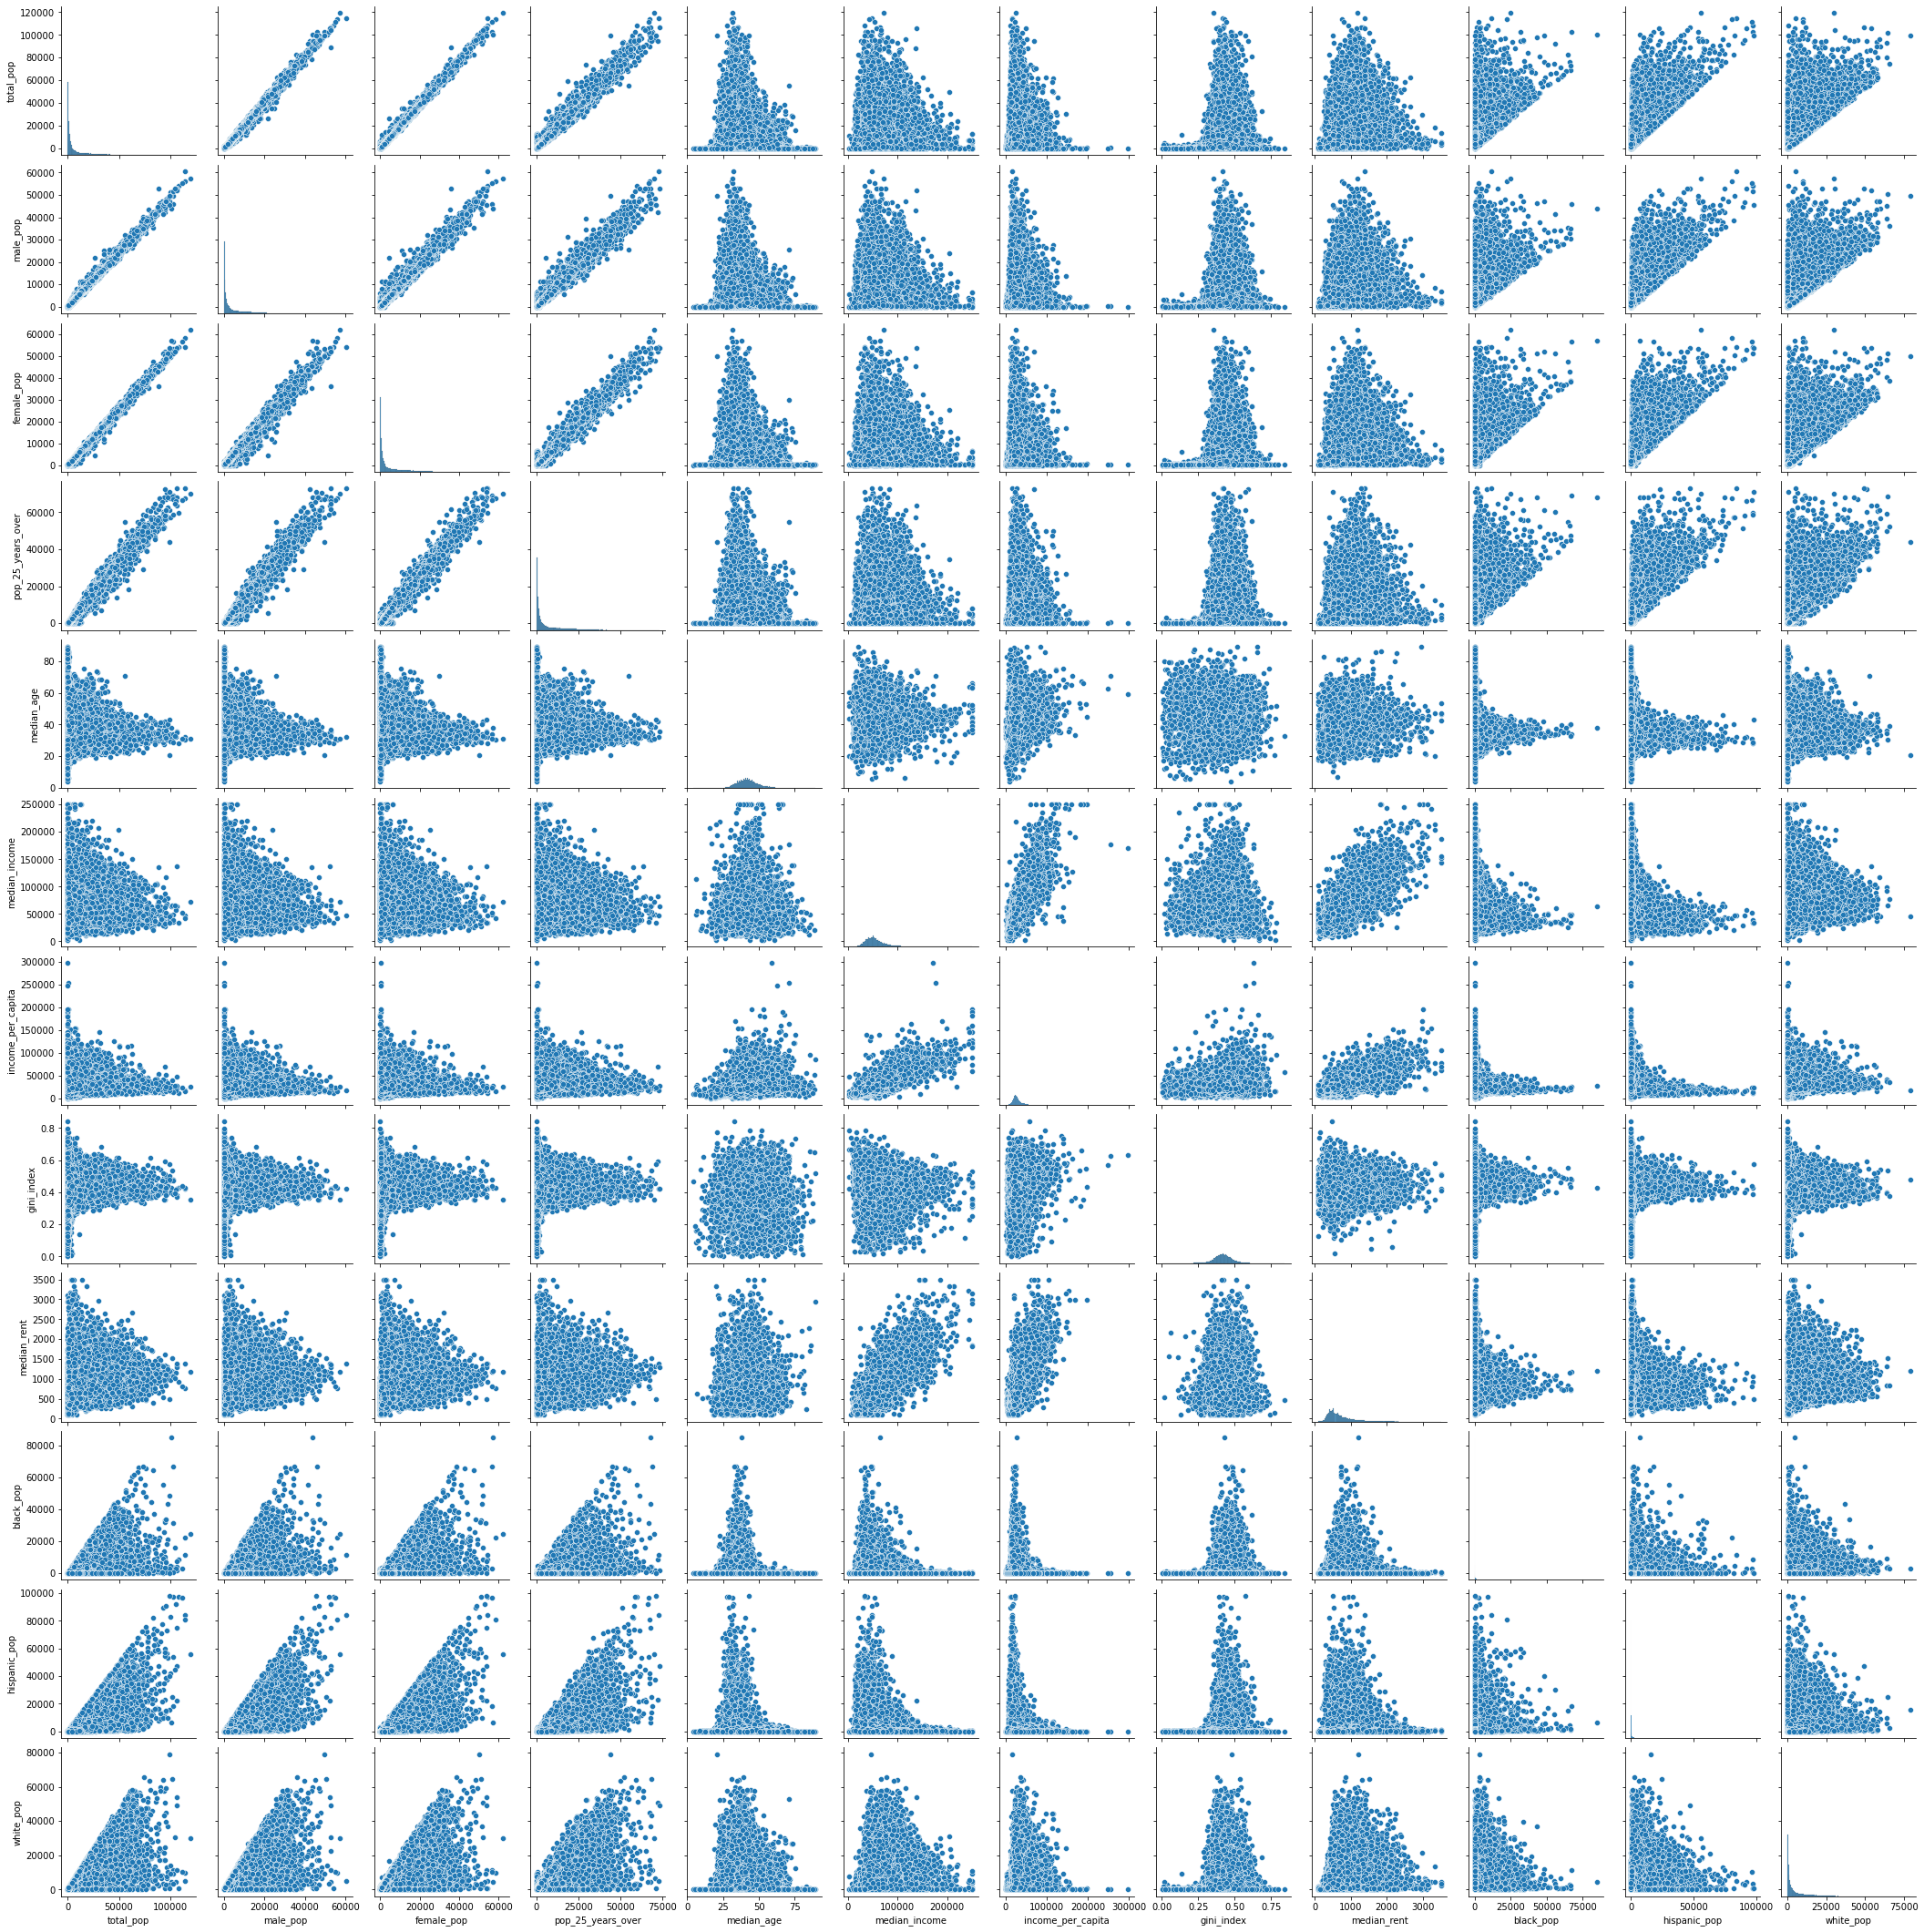

In [15]:
# Create the default pairplot - check if there's any obvious correlation
sns.pairplot(df[['total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']])

In [16]:
cluster_variables =  ['male_pop', 'female_pop', 'pop_25_years_over','median_age', 'median_income', 'income_per_capita',
                      'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']

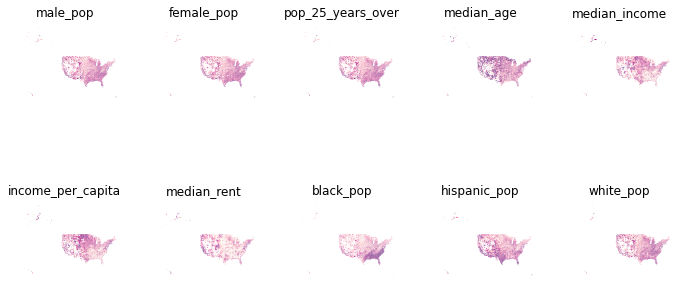

In [21]:
f, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [22]:
w = Queen.from_dataframe(gdf)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 332 disconnected components.
 There are 261 islands with ids: 318, 761, 872, 926, 957, 991, 1368, 1583, 1811, 3106, 3919, 4059, 4661, 4722, 5103, 5189, 6255, 6647, 6829, 8051, 8066, 8671, 9118, 9845, 9863, 10792, 10835, 11102, 12065, 12139, 12219, 12844, 12941, 14308, 15182, 15233, 15456, 15533, 16099, 16558, 16948, 17924, 18577, 18643, 18723, 18792, 18862, 18869, 19019, 19029, 19064, 19113, 19359, 19436, 19464, 19540, 19567, 19588, 19605, 19650, 19667, 19682, 19687, 19721, 19812, 19885, 19974, 19996, 20046, 20059, 20088, 20092, 20172, 20214, 20234, 20269, 20300, 20308, 20346, 20402, 20443, 20505, 20508, 20521, 20532, 20537, 20569, 20572, 20581, 20692, 20788, 20795, 20809, 20842, 20844, 20888, 21006, 21068, 21070, 21144, 21159, 21164, 21197, 21248, 21269, 21272, 21306, 21308, 21325, 21335, 21339, 21342, 21416, 21457, 21504, 21545, 2157

In [25]:
#calculate Moran I 
#This will measure the extent to which each variable contains spatial structure:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(gdf[variable], w) for variable in cluster_variables]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim) for variable,res in zip(cluster_variables, mi_results)
]


In [26]:
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

,Moran's I,P-value
Variable,,
male_pop,0.538255,0.001
female_pop,0.545646,0.001
pop_25_years_over,0.545578,0.001
median_age,NaN,0.001
median_income,NaN,0.001
income_per_capita,NaN,0.001
median_rent,NaN,0.001
black_pop,0.602064,0.001
hispanic_pop,0.650845,0.001


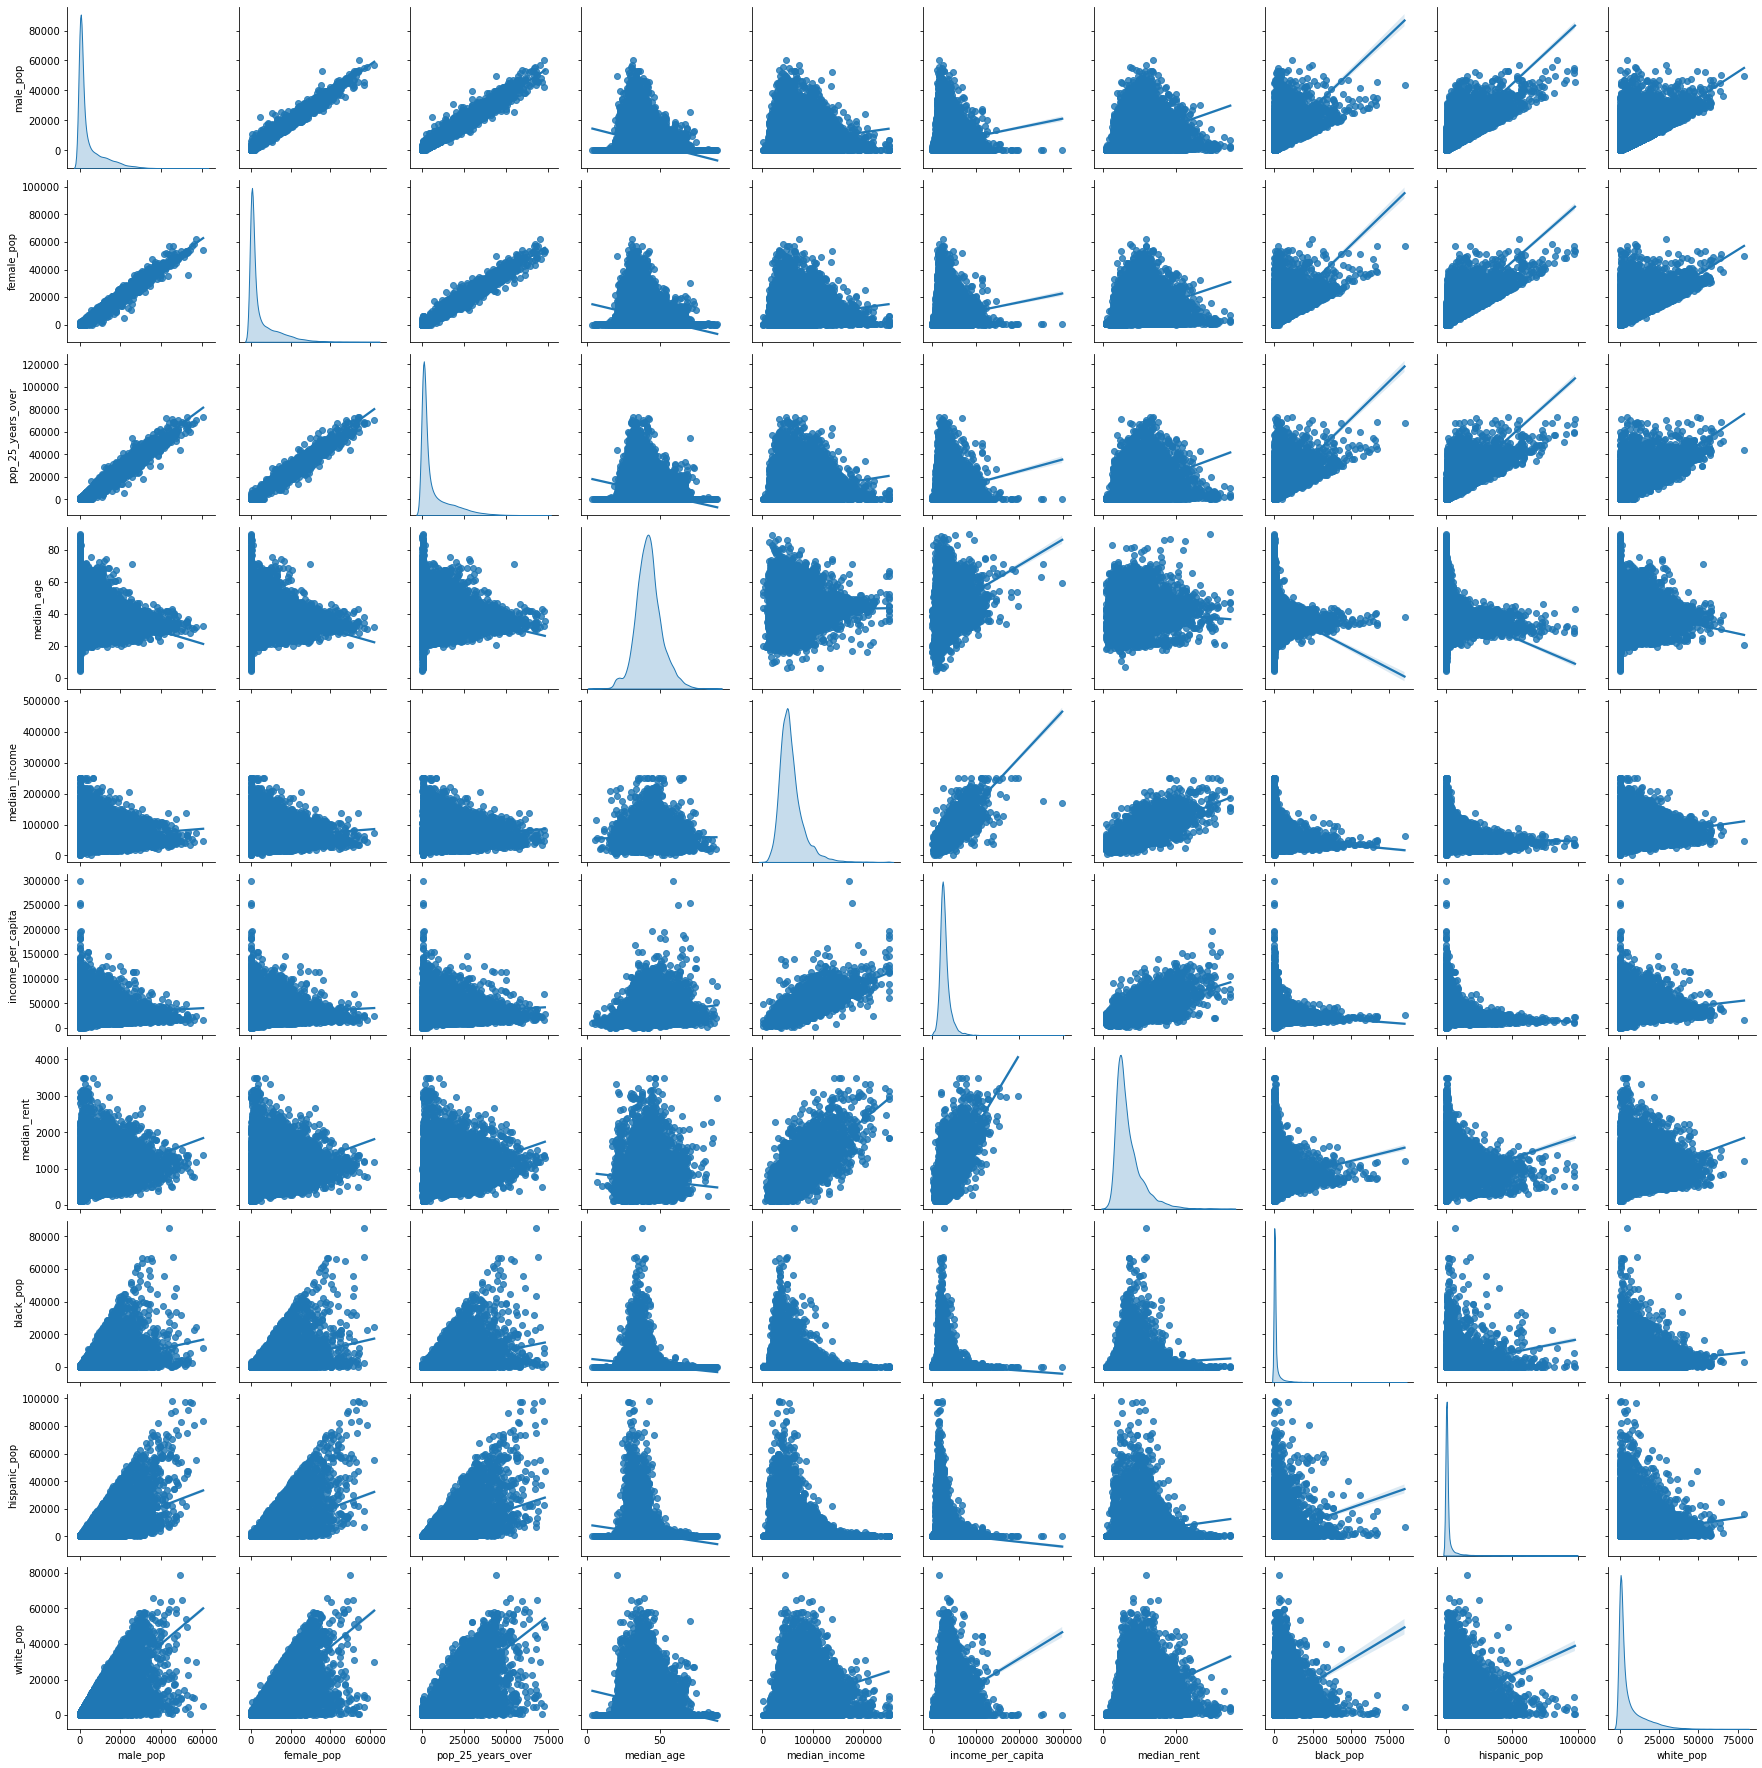

In [28]:
# diagonal elements  are the density functions for the  attributes
_ = sns.pairplot(gdf[cluster_variables], kind='reg', diag_kind='kde')

In [31]:
# Initialise KMeans instance
from sklearn.cluster import KMeans
from sklearn.preprocessing import robust_scale

In [32]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

In [35]:
gdf.isna().sum()

ID                      0
total_pop               0
male_pop                0
female_pop              0
pop_25_years_over       0
median_age            567
median_income        2159
income_per_capita     642
gini_index            907
median_rent          6088
black_pop               0
hispanic_pop            0
white_pop               0
geom                    0
geometry                0
dtype: int64

In [37]:
gdf.dropna(inplace=True)

In [38]:
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
#robust scale to scale the variables

k5cls = kmeans.fit(robust_scale(gdf[cluster_variables]))

In [39]:
k5cls.labels_

array([4, 1, 1, ..., 1, 1, 1])

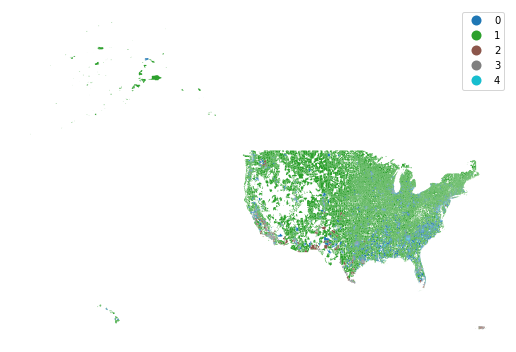

In [67]:
# Assign labels into a column
gdf['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [59]:
#creating polygon centroids to use them for clustering

centr = gdf.copy()
#going to centroids

centr['geometry'] = centr['geometry'].to_crs(epsg=5070).centroid

In [74]:
centr.head()

,ID,total_pop,male_pop,female_pop,pop_25_years_over,median_age,median_income,income_per_capita,gini_index,median_rent,black_pop,hispanic_pop,white_pop,geom,geometry,k5cls,ward5
0,0,48970,24123,24847,26944,27.0,51972.0,21486.0,0.3620,853.0,16810,11761,14301,"MULTIPOLYGON(((-97.874316 31.077931, -97.87367...",POINT (-174199.415 883605.450),4,1
1,1,809,376,433,612,56.2,29087.0,21153.0,0.4452,370.0,127,31,651,"POLYGON((-95.793207 32.036901, -95.805474 32.0...",POINT (17580.528 984770.230),1,0
2,2,2330,1198,1132,1650,46.0,56400.0,29967.0,0.4528,533.0,276,254,1691,"POLYGON((-79.073703 35.659202, -79.074482 35.6...",POINT (1509102.133 1532035.312),1,0
3,3,22171,11234,10937,15022,38.3,73226.0,30397.0,0.4187,1297.0,377,11256,8195,"POLYGON((-121.71859 36.814383, -121.715383 36....",POINT (-2242347.813 1829618.739),0,1
4,4,2829,1485,1344,2033,41.2,35064.0,20576.0,0.4633,481.0,41,21,2727,"POLYGON((-81.587423 37.749221, -81.595335 37.7...",POINT (1257252.371 1728982.306),1,0


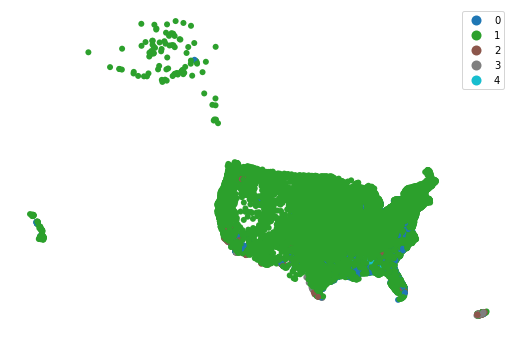

In [76]:

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
centr.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0,aspect=1, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [77]:
clusters = centr['k5cls'].unique()

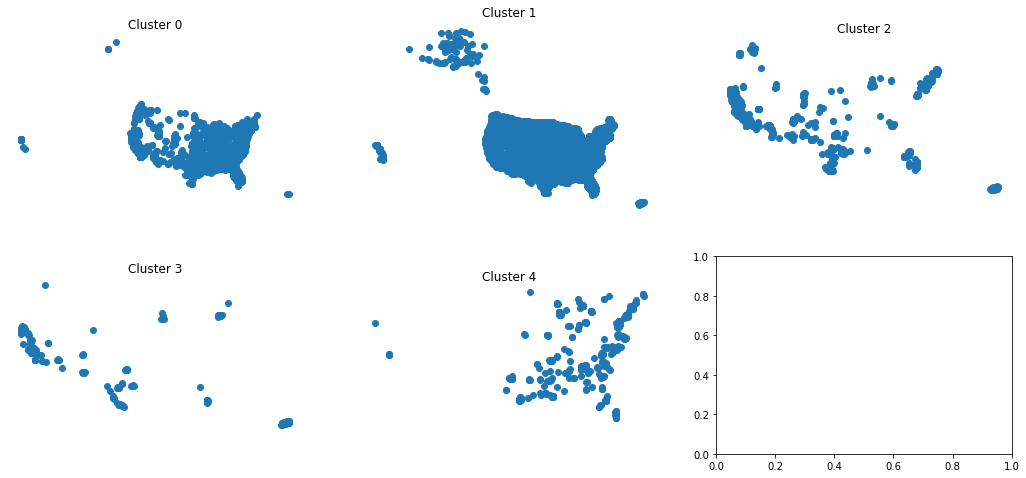

In [78]:
# Create figure and axes 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()

for i in clusters:
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    centr.loc[(centr['k5cls']==i)].plot(ax=ax)
   
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title('Cluster '+str(i))
# Display the figure
plt.show()

In [60]:
from sklearn.cluster import AgglomerativeClustering

In [66]:
#k-means and Ward’s hierarchical method.

Applying a regionalization approach is not always required but it can provide additional insights into the spatial structure of the multivariate statistical relationships that traditional clustering is unable to articulate.

In [61]:
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(robust_scale(gdf[cluster_variables]))
# Assign labels to main data table
gdf['ward5'] =model.labels_

In [62]:
ward5sizes = gdf.groupby('ward5').size()
ward5sizes

ward5
0    23337
1     1592
2      321
3      233
4     1240
dtype: int64

**Hierarchical Clustering and  Spatially Constrained Hierarchical Clustering (contiguity constraint ) is not going to work well as dataset contains gaps**